# qecsim demos

## Simulating error correction with a planar stabilizer code
This demo shows verbosely how to simulate one error correction run. 

| For normal use, the code in this demo is encapsulated in the function:
| `qecsim.app.run_once(code, error_model, decoder, error_probability)`,
| and the simulation of many error correction runs is encapsulated in the function:
| `qecsim.app.run(code, error_model, decoder, error_probability, max_runs, max_failures)`.

Notes:

* Operators can be visualised in binary symplectic form (bsf) or Pauli form, e.g. `[1 1 0|0 1 0] = XYI`.
* The binary symplectic product is denoted by $\odot$ and defined as $A \odot B \equiv A \Lambda B \bmod 2$ where $\Lambda = \left[\begin{matrix} 0 & I \\ I & 0 \end{matrix}\right]$.
* Binary addition is denoted by $\oplus$ and defined as addition modulo 2, or equivalently exclusive-or.

### Initialise the models

In [1]:
%run qsu.ipynb  # color-printing functions
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel
from qecsim.models.planar import PlanarCode, PlanarMWPMDecoder, PlanarMPSDecoder
from _planarmpsdecoder_def import PlanarMPSDecoder_def

# initialise models
my_code = PlanarCode(4, 4)
my_error_model = DepolarizingErrorModel()
my_decoder = PlanarMPSDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)

PlanarCode(4, 4)
DepolarizingErrorModel()
PlanarMPSDecoder(None, 'c', None, None)


### Generate a random error

In [2]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(59)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error:\n{}'.format(my_code.new_pauli(error)))

In [4]:
error

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [51]:
for i in range(my_code.n_k_d[0]):
    error2=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])
    error2[i]=1
    qsu.print_pauli('error:\n{}'.format(my_code.new_pauli(error2)))

In [52]:
error2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [56]:
error3=my_code.new_pauli(error2)
for row,col in np.ndindex((7,7)):
    if row%2==0 and col%2==0:
        print(row,col,error3.operator((row,col)))
    elif row%2==1 and col%2==1:
        print(row,col,error3.operator((row,col)))   

0 0 I
0 2 I
0 4 I
0 6 I
1 1 I
1 3 I
1 5 I
2 0 I
2 2 I
2 4 I
2 6 I
3 1 I
3 3 I
3 5 I
4 0 I
4 2 I
4 4 I
4 6 I
5 1 I
5 3 I
5 5 X
6 0 I
6 2 I
6 4 I
6 6 I


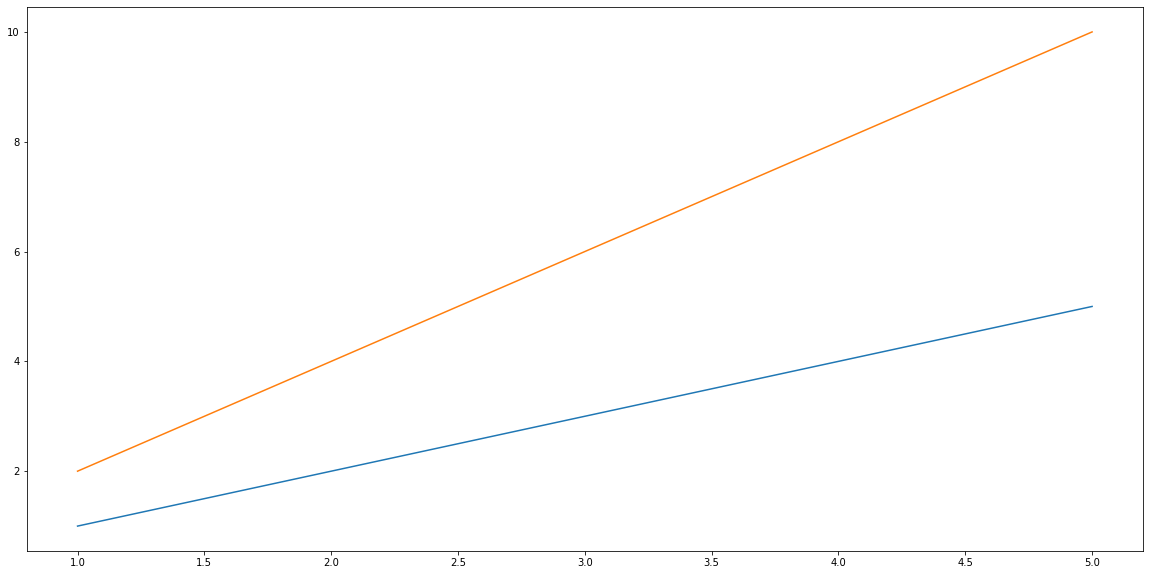

In [73]:
x=[1,2,3,4,5]
y=x
y2=[yel*2 for yel in y]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x,y,label='first')
# plt.legend('first')
plt.plot(x,y2)
# plt.legend('123')

In [74]:
for pYZ in np.linspace(1/4,1/2,5):
    print(str(pYZ))

0.25
0.3125
0.375
0.4375
0.5


In [76]:
str(pYZ)+'hello'

'0.5hello'

### Evaluate the syndrome
The syndrome is a binary array indicating the stabilizers with which the error does not commute. It is calculated as $syndrome = error \odot stabilisers^T$.

In [3]:
# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
qsu.print_pauli('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

### Find a recovery operation
In this case, the recovery operation is found by a minimum weight perfect matching decoder that finds the recovery operation as follows:

* The syndrome is resolved to plaquettes using: `PlanarCode.syndrome_to_plaquette_indices`.
* For each plaquette, the nearest corresponding off-boundary plaquette is found using: `PlanarCode.virtual_plaquette_index`.
* A graph between plaquettes is built with weights given by: `PlanarMWPMDecoder.distance`.
* A MWPM algorithm is used to match plaquettes into pairs.
* A recovery operator is constructed by applying the shortest path between matching plaquette pairs using:
  `PlanarPauli.path`.

In [26]:
# recovery: best match recovery operation based on decoder
recovery=my_code.new_pauli()
recovery = my_decoder.decode(my_code,syndrome)
qsu.print_pauli('recovery:\n{}'.format(my_code.new_pauli(recovery)))
print(recovery[0:my_code.n_k_d[0]])
print(recovery[my_code.n_k_d[0]:2*my_code.n_k_d[0]])


TypeError: cannot unpack non-iterable int object

In [57]:
perm_mat_sample=np.zeros((7,7),dtype=int)
perm_mat=np.zeros(perm_mat_sample.shape,dtype=int)
n_qubits =my_code.n_k_d[0]
perm_vec=[]

for row,col in np.ndindex(perm_mat.shape):
    if row%2==0 and col%2==0:
        print(row,col)
for row,col in np.ndindex(perm_mat.shape):
    if row%2==1 and col%2==1:
        print(row,col)

0 0
0 2
0 4
0 6
2 0
2 2
2 4
2 6
4 0
4 2
4 4
4 6
6 0
6 2
6 4
6 6
1 1
1 3
1 5
3 1
3 3
3 5
5 1
5 3
5 5


In [58]:
code='random_allll'
code[:6]

'random'

As a sanity check, we expect $recovery \oplus error$ to commute with all stabilizers, i.e. $(recovery \oplus error) \odot stabilisers^T = 0$.

In [97]:
# check recovery ^ error commutes with stabilizers (by construction)
print(pt.bsp(recovery, my_code.stabilizers.T))
recovery

[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### Visualise $recovery \oplus error$
Just out of curiosity, we can see what $recovery \oplus error$ looks like. If successful, it should be a product of stabilizer plaquette / vertex operators.

In [17]:
# print recovery ^ error (out of curiosity)
qsu.print_pauli('recovery ^ error:\n{}'.format(my_code.new_pauli(recovery ^ error)))

### Test if the recovery operation is successful
The recovery operation is successful iff $recovery \oplus error$ commutes with all logical operators, i.e. $(recovery \oplus error) \odot logicals^T = 0.$

In [18]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(recovery ^ error, my_code.logicals.T))

[0 0]


Note: The decoder is not guaranteed to find a successful recovery operation. The planar 5 x 5 code has distance $d = 5$ so we can only guarantee to correct errors up to weight $(d - 1)/2=2$.

### Equivalent code in single call
The above demo is equivalent to the following code.

In [19]:
# repeat demo in single call
from qecsim import app
print(app.run_once(my_code, my_error_model, my_decoder, error_probability))

{'error_weight': 2, 'success': True, 'logical_commutations': array([0, 0]), 'custom_values': None}


In [20]:
recovery.code

AttributeError: 'numpy.ndarray' object has no attribute 'code'

In [39]:
sample_pauli=recovery
tn = np.empty((2 * sample_pauli.code.size[0] - 1, 2 * sample_pauli.code.size[1] - 1), dtype=object)
# index to direction maps
row_to_direction = {0: 'n', tn.shape[0] - 1: 's'}
col_to_direction = {0: 'w', tn.shape[1] - 1: 'e'}

In [40]:
row_to_direction.get(1,'')

''

In [30]:
{'n': (1, 2, 2, 2),
'ne': (1, 1, 2, 2),
'e': (2, 1, 2, 2),
'se': (2, 1, 1, 2),
's': (2, 2, 1, 2),
'sw': (2, 2, 1, 1),
'w': (2, 2, 2, 1),
'nw': (1, 2, 2, 1),}.get('se')

(2, 1, 1, 2)

In [34]:
import functools
import json
import logging
import operator

import numpy as np
from mpmath import mp

from qecsim import paulitools as pt, tensortools as tt
from qecsim.model import Decoder, cli_description
from qecsim.models.generic import DepolarizingErrorModel
recovery=sample_recovery(my_code, syndrome)

In [30]:
recovery.operator

<bound method PlanarPauli.operator of PlanarPauli(PlanarCode(4, 4), array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))>

In [32]:
for row,col in np.ndindex((4,4)):
    if row%2==0 and col%2==0:
        print(row,col,recovery.operator((row,col)))

0 0 I
0 2 X
2 0 I
2 2 X


In [27]:
def sample_recovery(code, syndrome):
        """
        Return a sample Pauli consistent with the syndrome, created by applying a path between each plaquette identified
        by the syndrome and the nearest boundary of the same type as the plaquette.

        :param code: Planar code.
        :type code: PlanarCode
        :param syndrome: Syndrome as binary vector.
        :type syndrome: numpy.array (1d)
        :return: Sample recovery operation as planar pauli.
        :rtype: PlanarPauli
        """
        # prepare sample
        sample_recovery = code.new_pauli()
        # ask code for syndrome plaquette_indices
        plaquette_indices = code.syndrome_to_plaquette_indices(syndrome)
        # for each plaquette
        for index in plaquette_indices:
            # find nearest off-boundary plaquette
            virtual_index = code.virtual_plaquette_index(index)
            # add path to boundary
            sample_recovery.path(index, virtual_index)
        # return sample
        return sample_recovery

In [43]:
sample_pauli.operator((2,2))

'Y'

In [45]:
def node_shape(compass_direction=None):
            """Return shape of tensor including dummy indices."""
            return {
                'n': (1, 2, 2, 2),
                'ne': (1, 1, 2, 2),
                'e': (2, 1, 2, 2),
                'se': (2, 1, 1, 2),
                's': (2, 2, 1, 2),
                'sw': (2, 2, 1, 1),
                'w': (2, 2, 2, 1),
                'nw': (1, 2, 2, 1),
            }.get(compass_direction, (2, 2, 2, 2))


In [46]:
node_shape()

(2, 2, 2, 2)

In [48]:
def h_node_value(prob_dist, f, n, e, s, w):
            """Return horizontal edge tensor element value."""
            paulis = ('I', 'X', 'Y', 'Z')
            op_to_pr = dict(zip(paulis, prob_dist))
            f = pt.pauli_to_bsf(f)
            I, X, Y, Z = pt.pauli_to_bsf(paulis)
            # n, e, s, w are in {0, 1} so multiply op to turn on or off
            op = (f + (n * Z) + (e * X) + (s * Z) + (w * X)) % 2
            return op_to_pr[pt.bsf_to_pauli(op)]


In [62]:
h_node_value([0.1,0.3,0.4,0.2],'X',0,1,1,1)

0.4

In [61]:
node = np.empty(node_shape('n'), dtype=np.float64)
for n, e, s, w in np.ndindex(node.shape):
    print(n,e,s,w,h_node_value([0.1,0.3,0.4,0.0],'Z',n,e,s,w))

0 0 0 0 0.0
0 0 0 1 0.4
0 0 1 0 0.1
0 0 1 1 0.3
0 1 0 0 0.4
0 1 0 1 0.0
0 1 1 0 0.3
0 1 1 1 0.1


In [69]:
paulis = ('I', 'X', 'Y', 'Z')
prob_dist=[0.1,0.3,0.4,0.2]
op_to_pr = dict(zip(paulis, prob_dist))
print(op_to_pr)



{'I': 0.1, 'X': 0.3, 'Y': 0.4, 'Z': 0.2}


In [71]:
f=pt.pauli_to_bsf('Z')
print(f)

[0 1]


In [75]:
op_to_pr['X']

0.3

In [76]:
I, X, Y, Z = pt.pauli_to_bsf(paulis)
print(I,X,Y,Z)

[0 0] [1 0] [1 1] [0 1]


In [80]:
op=(f+1*I+1*Y)%2
print(op)
op_to_pr[pt.bsf_to_pauli(op)]

[1 0]


0.3

In [82]:
direction = row_to_direction.get(0, '')+col_to_direction.get(0, '')

In [83]:
direction

'nw'

In [113]:
for row,col in np.ndindex((5,5)):
    if row%2==0 and col%2==0:
        print(row,col)

0 0
0 2
0 4
2 0
2 2
2 4
4 0
4 2
4 4
